# Prática 02 - k-NN e Avaliação de Classificadores

In [90]:
# Celula de definicao das libraries/dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice
# Importe outras libraries que vc ira usar aqui!
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, make_scorer
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import plotly.express as px

# Lembre que o dataset da prática 1 é o do link abaixo
titanic = pd.read_csv('https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/train.csv')

In [99]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Initially we can drop Cabin, PassengerId, Name, Ticket, Embarked, since these conceptually add little to no value to our classification task.
Age has a lot of null values, so we should deal with this. First let's take a look at how age is distributed to know what to do.

In [100]:
px.histogram(titanic, 'Age', nbins=80)

In [111]:
px.box(titanic, 'Age')

In [110]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The age distribution doesn't appear to follow a Normal Distribution, so the mean might not be very representative of the data, plus there is the presence of high outliers, which pull the mean up. We see, however, that the median, or 50% quantile is very close to the mean, and closer to where most of the data is concentrated so we may use it to fill null values.

In [101]:
def get_df_pipeline1(df: pd.DataFrame):
  df = df.copy()

  median_age = titanic['Age'].median()
  df['Age'].fillna(median_age, inplace=True)

  df.drop(['Cabin', 'PassengerId', 'Name', 'Ticket', 'Embarked'], axis=1, inplace=True)

  # encoding
  le = preprocessing.LabelEncoder()
  df['Sex_Encoded'] = le.fit_transform(df['Sex'])
  df.drop(['Sex'], axis=1, inplace=True)

  return df

In [102]:
df = get_df_pipeline1(titanic)

/var/folders/2q/7bbngnyx7sz9bdzd422szlbh0000gp/T/ipykernel_58071/4227628289.py:5: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Age          891 non-null    float64
 3   SibSp        891 non-null    int64  
 4   Parch        891 non-null    int64  
 5   Fare         891 non-null    float64
 6   Sex_Encoded  891 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 48.9 KB


In [113]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_Encoded
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208,0.647587
std,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429,0.477990
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,1.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


We observe the standard deviation reduced. This happens when we introduce many new values close to the mean, so the data is less scattered around the mean.

**Fique a vontade de usar a função [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) do Sklearn também =)**

## Parte 2 - Experimento I - Classificação k-NN TODO: DIFERENTES K, COMENTAR

**Pontuação: 35 pontos**

Nesta primeira parte nosso objetivo será criar o melhor classificador possível para predizer o status de 'Survived' das instâncias da base do Titanic. Dessa forma, vocês possuem o desafio de criar um classificador com o k-NN. Note que vocês possuem a missão de definir os parâmetros do classificador (valor de k, métrica de distância utilizada e etc).

Para seguir com este desafio, siga as etapas abaixo:


1.   Divida seu dataset utilizando o Método Holdout com 70%/30% (sem validação cruzada!).
2.   **Crie um classificador k-NN com o conjunto de treinamento**.
3.   Use o classificador criado em (2) para avaliar o resultado na base de teste. **Apresente o resultado do seu melhor classificador indicando os parâmetros do mesmo (valor de k, métrica de distância). Apresente a matriz de confusão para a base de teste para seu melhor classificador.**

PS: Sinta-se à vontade para criar gráficos. Lembre das etapas importantes ao considerar o treinamento e teste do k-NN!

**DICAS:**

*   Usar GridSearch para definir os melhores parâmetros para classificador. Confira este [artigo](https://www.datasklr.com/select-classification-methods/k-nearest-neighbors)




### Preprocessing

In [118]:
def preprocess_titanic_knn(df: pd.DataFrame):
    titanic_y = df["Survived"]
    titanic_x = df.copy()
    titanic_x.drop("Survived", axis=1, inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(titanic_x, titanic_y, test_size=0.30, random_state=42)

    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)

    test_scaler = preprocessing.StandardScaler()
    X_test = test_scaler.fit_transform(X_test)

    return X_train, X_test, y_train, y_test

In [120]:
X_train, X_test, y_train, y_test = preprocess_titanic_knn(df)

## Baseline Model, testing values for K, no CV

In [123]:
def plot_confusion_matrix(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)

  # Plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.set(font_scale=1.4)  # for label size
  sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()

In [129]:
k_values = [i for i in range (1,31, 2)]
accuracies = []

for k in k_values:
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append([accuracy, k, y_test, y_pred])

max = [-1, 0]
for i in accuracies:
  if i[0] > max[0]:
    max = i

print(max[0], max[1])

0.8208955223880597 5


Observe that the current best value for K is 5, with an accuracy of 82.0895%

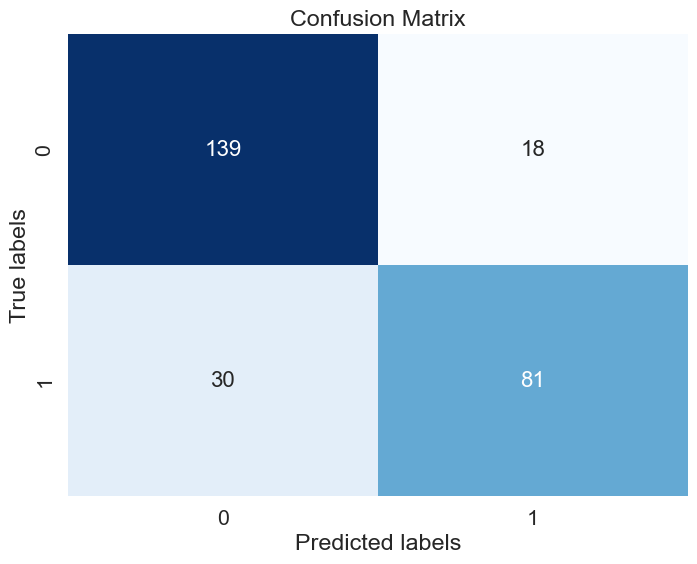

In [130]:
y_test, y_pred = max[2], max[3]
plot_confusion_matrix(y_test, y_pred)